In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import pandas as pd
import numpy as np

### Load in data

In [2]:
total_data = pd.read_csv("data/stats2.csv.gz", parse_dates=[0], index_col=[0])

total_data['mem_rss_GB'] = total_data['mem_rss'] / (1024**3)
total_data['mem_vms_GB'] = total_data['mem_vms'] / (1024**3)
total_data['name'] = total_data.name.astype(str)

/opt/homebrew/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
total_data.head(2)

,pid,name,num_threads,cpu_num,cpu_user,cpu_system,cpu_iowait,cpu_children_system,cpu_children_user,idle,...,memory_percent,num_fds,read_count,write_count,read_chars,write_chars,cmdline,current_dir,mem_rss_GB,mem_vms_GB
@timestamp,,,,,,,,,,,,,,,,,,,,,
2022-06-09 15:39:19.829589,65549,bash,1,66,0.0,0.0,0.0,0.0,0.00,NaN,...,0.000267,4,98.0,22.0,38700.0,214.0,bash|/global/cfs/projectdirs/jaws/jaws-install...,/global/cscratch1/sd/jaws_jtm/jaws-condor/work...,0.004025,0.024342
2022-06-09 15:39:19.835244,65552,bash,1,24,0.0,0.0,0.0,0.0,0.01,NaN,...,0.000267,4,98.0,22.0,38700.0,214.0,bash|/global/cfs/projectdirs/jaws/jaws-install...,/global/cscratch1/sd/jaws_jtm/jaws-condor/work...,0.004025,0.024342


### Sorts unique process names by the number of time points

In [4]:
name, counts = np.unique(total_data.name, return_counts=True)
_sort = np.argsort(counts)[::-1]

name = name[_sort]
counts = counts[_sort]

for n, c in zip(name, counts):
    print(n, c)

bash 79356
tee 52532
lastal5 26266
shard_reader.py 26263
sshd 97
top 60
less 5


### Aggregate processes by name and give a table

In [5]:
total_data.groupby('name').agg(
    {
        'mem_rss_GB': ['max', 'mean'],
        'mem_vms_GB': ['max', 'mean'],
        'num_threads' : ['max', 'mean'],
    }
)

mem_rss_GB             mem_vms_GB             num_threads  \
                        max       mean         max        mean         max   
name                                                                         
bash               0.007706   0.003018    0.027618    0.011658           1   
lastal5          322.056499  21.960596  322.076256  320.122567           1   
less               0.000862   0.000862    0.006420    0.006420           1   
shard_reader.py    0.018410   0.018404    0.024860    0.024857           1   
sshd               0.005444   0.005433    0.138969    0.138960           1   
tee                0.000652   0.000652    0.003864    0.003864           1   
top                0.006809   0.006633    0.075550    0.075518           1   

                      
                mean  
name                  
bash               1  
lastal5            1  
less               1  
shard_reader.py    1  
sshd               1  
tee                1  
top                1

### Plot the memory usage of the workflow over time

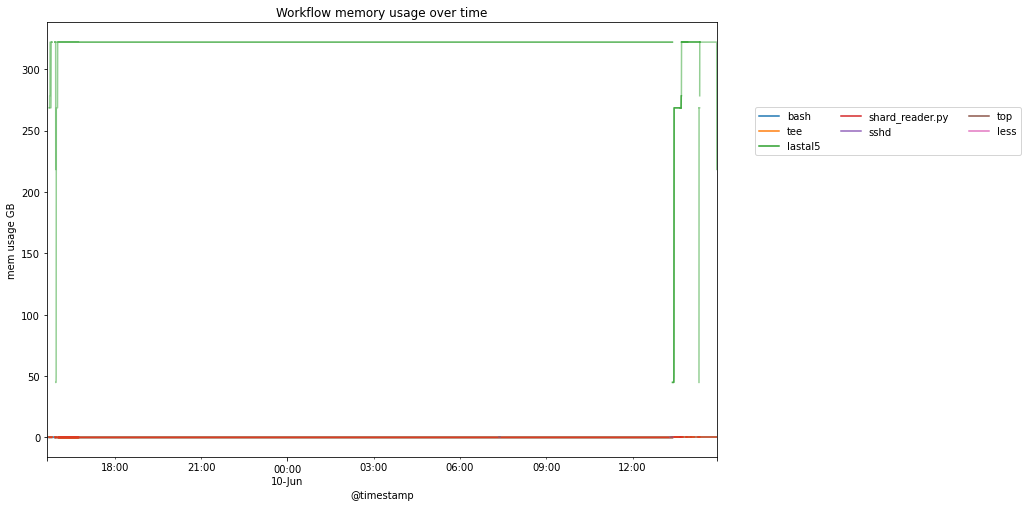

In [6]:
# remove duplicate legends
# https://stackoverflow.com/a/56253636
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    leg = ax.legend(*zip(*unique), loc='center left', bbox_to_anchor=(1.05, 0.75), ncol=3, fancybox=True)
    # Set legend to alpha=1.0
    # https://stackoverflow.com/a/42403471
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

fig, ax = plt.subplots(figsize=(12,8))
# Get a color map
cmap = cm.get_cmap('tab10')
colors = {}

# Give each process a unique color
for n, color in zip(name, cmap.colors):
    if n in colors.keys():
        continue
    else:
        colors[n] = color

# Plot the memory usage over time including all processes
for n, c in zip(name, counts):
    data = total_data[total_data['name'] == n]
    pids = data.pid.unique()

    for pid in pids:
        process_data = data[data.pid == pid]
        mem = process_data.mem_vms_GB.resample("10s").mean()
        try:
            mem.plot(c=colors[n], alpha=0.5, label=n)
        except KeyError:
            mem.plot(c='black', alpha=0.5)

legend_without_duplicate_labels(ax)
plt.title(f'Workflow memory usage over time')
plt.ylabel("mem usage GB")
plt.show()

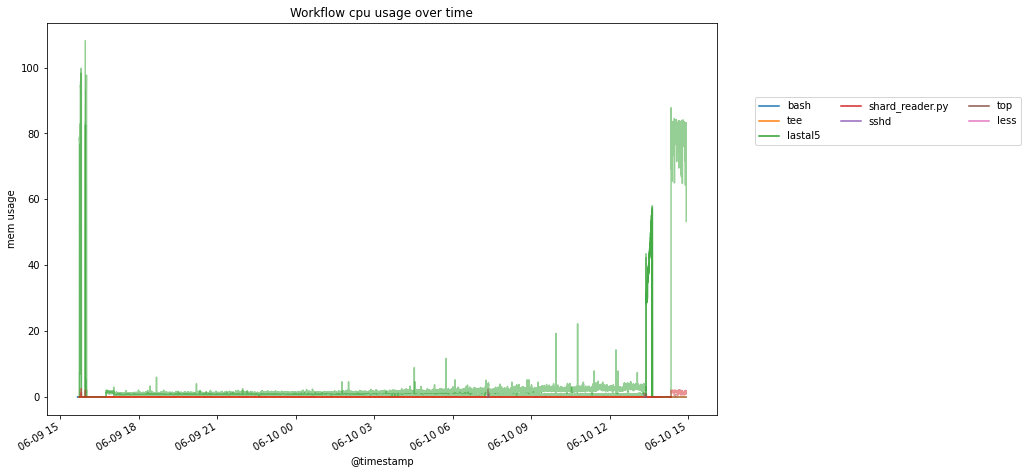

In [7]:
total_data.sort_index(inplace=True)

# remove duplicate legends
# https://stackoverflow.com/a/56253636
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    leg = ax.legend(*zip(*unique), loc='center left', bbox_to_anchor=(1.05, 0.75), ncol=3, fancybox=True)
    # Set legend to alpha=1.0
    # https://stackoverflow.com/a/42403471
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

fig, ax = plt.subplots(figsize=(12,8))
# Get a color map
cmap = cm.get_cmap('tab10')
colors = {}

# Give each process a unique color
for n, color in zip(name, cmap.colors):
    if n in colors.keys():
        continue
    else:
        colors[n] = color

# Plot the memory usage over time including all processes
for n, c in zip(name, counts):
    data = total_data[total_data['name'] == n]
    pids = data.pid.unique()

    for pid in pids:
        process_data = data[data.pid == pid]
        # This only works because we get the derivative over 10 seconds
        # You need to change a bit for different time intervals
        cpu = 10*(process_data.cpu_system + process_data.cpu_user + process_data.cpu_iowait).rolling('10s').apply(lambda x: x[-1] - x[0])
        cpu.resample('10s')
        try:
            cpu.plot(c=colors[n], alpha=0.5, label=n)
        except KeyError:
            cpu.plot(c='black', alpha=0.5)

legend_without_duplicate_labels(ax)
plt.title(f'Workflow cpu usage over time')
plt.ylabel("mem usage")
plt.show()